In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy import stats as sc_stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import tensorflow as tf

2023-04-23 09:59:40.246506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import sys
from os.path import dirname
sys.path.append(dirname("../"))

In [5]:
from src.weibull_edl import loss_and_layers

In [6]:
import matplotlib.pyplot as plt

In [7]:
%load_ext autoreload
%autoreload 2

### Read data

In [8]:
df_clean = pd.read_csv("../data/data_preprocessed_v0.csv",index_col=0)
df_clean.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,total_acc,acc_now_delinq,recovery_rate,CCF
member_id,,,,,,,,,,,,,,,,,,,,,
1314167,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,5.0,0.0,3.0,0.0,4.0,0.0,0.046832,0.817416
1306957,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.55,0.0,2.0,0.0,11.0,0.0,13.0,0.0,0.033761,0.971068
1306721,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.08,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.050100,0.874701
1298717,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.08,0.0,1.0,0.0,4.0,0.0,9.0,0.0,0.049367,0.860429
1303503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.06,0.0,2.0,0.0,14.0,0.0,29.0,0.0,0.064510,0.456653


In [9]:
y_cols = ["recovery_rate","CCF"]

In [52]:
(y>0.00).sum()

23300

In [54]:
df_clean1 = df_clean[df_clean.recovery_rate>0.00]
X = df_clean1.drop(columns=y_cols + list(df_clean.columns)[35:39])
y = df_clean1["recovery_rate"]*100 

X.shape,y.shape

((23300, 43), (23300,))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((17475, 43), (5825, 43), (17475,), (5825,))

### Estimate shape of weibull for y

In [56]:
rv = sc_stats.weibull_min.fit(y, floc=0)
rv

(1.1890561651969371, 0, 11.385575855882676)

In [57]:
sc_stats.weibull_min.pdf(y,*rv)

array([0.06235741, 0.06556923, 0.06134987, ..., 0.03391391, 0.03842998,
       0.03140155])

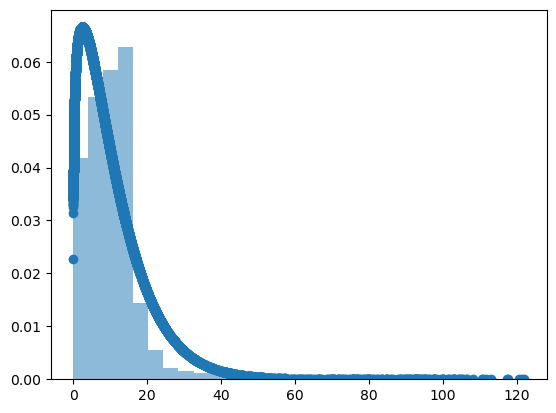

In [132]:
plt.hist(y,alpha=0.5,density=True,bins=30,label="Histogram of data")
plt.scatter(y, sc_stats.weibull_min.pdf(y,*rv),label="Fitted Weibull")

In [72]:
k=1.2

### Build model

In [117]:
edl_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=X.shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        loss_and_layers.DenseWeibullGamma(1),
    ])

def weibullLoss(true, pred):
        return loss_and_layers.weibull_evidence_Regression(true, pred, k=k, coeff=1e-1)

# Compile and fit the model!
edl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=weibullLoss)
    

In [118]:
edl_model.fit(X_train.values[:,:], y_train.values[:], batch_size=500, epochs=50)

Epoch 1/50
35/35 [==============================] - 1s 3ms/step - loss: 6860882.0000
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 12.2635
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 11.7612
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 11.6747
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 11.6050
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 11.6012
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5504
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5777
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5821
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5454
Epoch 11/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5434
Epoch 12/50
35/35 [==============================] - 0s 2ms/step - loss: 11.5579
Epoch 13/50
35/35 [=============

In [119]:
y_pred = edl_model.predict(X_test)
alpha,beta = y_pred[:,0],y_pred[:,1]

183/183 [==============================] - 0s 729us/step


In [120]:
from scipy.special import loggamma

In [121]:
alpha,beta

(array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 array([0.15397003, 0.12977953, 0.09351879, ..., 0.12186086, 0.12701651,
        0.13640003], dtype=float32))

In [122]:
mean_pred_log = loggamma((k*alpha-1)/k) - np.log(k) - ((alpha-1)/k)*np.log(beta)
mu = np.exp(mean_pred_log)

In [123]:
mu

array([4.6385956, 4.6385956, 4.6385956, ..., 4.6385956, 4.6385956,
       4.6385956], dtype=float32)

In [124]:
mean_squared_error(y_test,mu)

140.22997505341613

(array([1.98014352e+03, 5.40039142e+02, 1.04007538e+03, 8.28060017e+02,
        0.00000000e+00, 9.72070455e+02, 1.36809916e+03, 0.00000000e+00,
        8.00057988e+02, 1.26009133e+03, 5.76041751e+02, 1.22408872e+03,
        6.12044361e+02, 2.80020296e+02, 1.04407567e+03, 7.92057408e+02,
        2.52018266e+02, 4.68033923e+02, 6.12044361e+02, 0.00000000e+00,
        3.96028704e+02, 9.00065236e+02, 1.44010438e+02, 9.36067845e+02,
        4.80034793e+02, 1.08007828e+02, 7.92057408e+02, 6.12044361e+02,
        2.16015657e+02, 3.24023485e+02, 4.00028994e+02, 2.16015657e+02,
        3.96028704e+02, 7.20052189e+02, 2.16015657e+02, 6.12044361e+02,
        4.80034793e+02, 1.08007828e+02, 5.04036532e+02, 6.48046970e+02,
        7.56054798e+02, 8.00057988e+02, 8.64062627e+02, 9.36067845e+02,
        1.36809916e+03, 3.96028704e+02, 1.44010438e+03, 1.84013337e+03,
        1.08007828e+03, 1.76988828e+05]),
 array([4.63836145, 4.63836622, 4.63837099, 4.63837528, 4.63838005,
        4.63838482, 4.6383

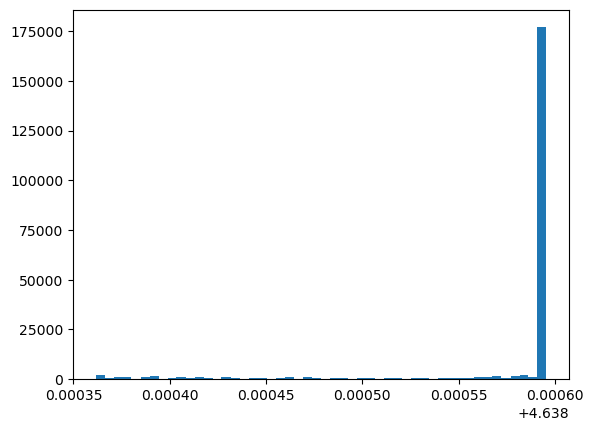

In [125]:
plt.hist(mu,bins=50,density=True)

In [69]:
edl_model.predict(X_test)

183/183 [==============================] - 0s 1ms/step


array([[1.7279198e+17, 1.6998290e+17],
       [1.9909627e+17, 1.9585956e+17],
       [2.5875091e+17, 2.5454440e+17],
       ...,
       [2.1160929e+17, 2.0816916e+17],
       [1.9598071e+17, 1.9279466e+17],
       [1.7157451e+17, 1.6878522e+17]], dtype=float32)

In [ ]:
y_test

In [ ]:
weibullLoss(y_test,edl_model.predict(X_test))

In [21]:
edl_model.predict(X_test)

320/320 [==============================] - 0s 694us/step


array([[1.108159  , 0.1165923 ],
       [1.1039628 , 0.1122489 ],
       [1.0514863 , 0.05717027],
       ...,
       [1.0977554 , 0.10580984],
       [1.0489044 , 0.05441312],
       [1.0936749 , 0.10156785]], dtype=float32)